# 01 - Manhattan Subway Data Integration and Quality Assessment
*Data Preparation for Ridership Prediction*

## Data Sources

### 1. MTA Subway Hourly Ridership (2024, Manhattan Only)
- **File:** `MTA_Subway_Hourly_Ridership__Manhattan_2024.csv`
- **Source:** [NY Open Data – MTA Subway Hourly Ridership (2020–2024)](https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data)
- **Format:** CSV
- **Filters Applied Before Downloading:**
  - `transit_timestamp` between **Jan 01, 2024** and **Jan 01, 2025**
  - `transit_mode` is **Subway**
  - `Borough` is **Manhattan**
- **Reference Files:**
  - `MTA_SubwayHourlyRidership_DataDictionary.pdf`
  - `MTA_SubwayHourlyRidership_Overview.pdf`

### 2. MTA Subway Stations Metadata (Manhattan Only)
- **File:** `MTA_Subway_Stations_Manhattan.csv`
- **Source:** [NY Open Data – MTA Subway Stations](https://data.ny.gov/Transportation/MTA-Subway-Stations/39hk-dx4f/about_data)
- **Format:** CSV
- **Filters Applied Before Downloading:**
  - `Borough` is **M** (Manhattan)
- **Reference Files:**
  - `MTA_SubwayStations_DataDictionary.pdf`
  - `MTA_SubwayStations_Overview.pdf`

---

**Objective:** Integrate Manhattan subway ridership data with station metadata and perform comprehensive quality assessment

**Data Sources:**
- MTA Subway Hourly Ridership (Manhattan 2024)
- MTA Subway Stations (Manhattan)

**Expected Parameters:**
- Manhattan station complexes: 121
- Hours in 2024: 8,784 (366 days × 24 hours, leap year)
- Adjusted for Daylight Saving Time (DST):
  - Spring Forward (March 10, 2024): 2 AM is skipped → 1 hour missing
  - Fall Back (November 3, 2024): 1 AM occurs twice → 1 extra hour, but we aggregate both
- Net adjustment: -1 hour
- Final expected hours: 8,783
- Expected total station-hour records: 121 × 8,783 = 1,063,743

---

In [1]:
# =======================
# Setup and Configuration
# =======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Display and plot settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('default')
sns.set_palette("husl")

# Logging
print("Manhattan Subway Data Integration and Quality Assessment")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Objective: Integrate ridership data with station metadata and assess quality")
print("=" * 60)

# =====================
# Define Project Paths
# =====================

# Use VS Code-friendly directory resolution
NOTEBOOK_DIR = Path().resolve()
PROJECT_DIR = NOTEBOOK_DIR.parent

# Data directories
DATA_DIR = PROJECT_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Input files
RIDERSHIP_FILE = RAW_DIR / "mta" / "MTA_Subway_Hourly_Ridership_Manhattan_2024.csv"
STATIONS_FILE = RAW_DIR / "mta" / "MTA_Subway_Stations_Manhattan.csv"

# Output files
OUTPUT_PARQUET = PROCESSED_DIR / "subway_data_cleaned.parquet"
QUALITY_JSON = PROCESSED_DIR / "subway_data_quality_assessment.json"

# Create processed directory if needed
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Show paths
print(f"\nPath Verification:")
print(f"  Raw ridership file: {RIDERSHIP_FILE}")
print(f"  Raw stations file:  {STATIONS_FILE}")
print(f"  Output (parquet):   {OUTPUT_PARQUET}")
print(f"  Output (quality):   {QUALITY_JSON}")


Manhattan Subway Data Integration and Quality Assessment
Analysis Date: 2025-07-28 19:41:18
Objective: Integrate ridership data with station metadata and assess quality

Path Verification:
  Raw ridership file: C:\Users\neasa\manhattan-subway\data\raw\mta\MTA_Subway_Hourly_Ridership_Manhattan_2024.csv
  Raw stations file:  C:\Users\neasa\manhattan-subway\data\raw\mta\MTA_Subway_Stations_Manhattan.csv
  Output (parquet):   C:\Users\neasa\manhattan-subway\data\processed\subway_data_cleaned.parquet
  Output (quality):   C:\Users\neasa\manhattan-subway\data\processed\subway_data_quality_assessment.json


In [2]:
# =====================
# Configuration
# =====================

from pathlib import Path

# Use resolved notebook and project paths
NOTEBOOK_DIR = Path().resolve()
PROJECT_DIR = NOTEBOOK_DIR.parent

# Data directories
DATA_DIR = PROJECT_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Create output folder if it doesn't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Constants for Manhattan Subway System
EXPECTED_STATIONS = 121
EXPECTED_HOURS_2024 = 8784  # 366 days × 24 hours
EXPECTED_TOTAL_RECORDS = EXPECTED_STATIONS * (EXPECTED_HOURS_2024 - 1)  # Account for DST

# Output expected parameters
print("\nExpected Parameters:")
print(f"  Expected station complexes: {EXPECTED_STATIONS}")
print(f"  Expected hours in 2024:     {EXPECTED_HOURS_2024}")
print(f"  Total expected records:     {EXPECTED_TOTAL_RECORDS:,}")

# Verify RAW_DIR structure
print(f"\nPath Verification:")
print(f"  Current working directory:  {NOTEBOOK_DIR}")
print(f"  RAW_DIR:                    {RAW_DIR.resolve()}")
print(f"  RAW_DIR exists:             {RAW_DIR.exists()}")

if RAW_DIR.exists():
    print("  Files in RAW_DIR:")
    for file in RAW_DIR.rglob("*"):
        print(f"    - {file.relative_to(RAW_DIR.parent)}")



Expected Parameters:
  Expected station complexes: 121
  Expected hours in 2024:     8784
  Total expected records:     1,062,743

Path Verification:
  Current working directory:  C:\Users\neasa\manhattan-subway\notebooks
  RAW_DIR:                    C:\Users\neasa\manhattan-subway\data\raw
  RAW_DIR exists:             True
  Files in RAW_DIR:
    - raw\manhattan_taxi_zones.csv
    - raw\mta
    - raw\weather_data.csv
    - raw\mta\MTA_SubwayHourlyRidership_DataDictionary.pdf
    - raw\mta\MTA_SubwayHourlyRidership_Overview.pdf
    - raw\mta\MTA_SubwayStations_DataDictionary.pdf
    - raw\mta\MTA_SubwayStations_Overview.pdf
    - raw\mta\MTA_Subway_Hourly_Ridership_Manhattan_2024.csv
    - raw\mta\MTA_Subway_Stations_Manhattan.csv


In [3]:
# ============================================
# 1. Loading and Examining Ridership Data
# ============================================

print("\n" + "=" * 60)
print("1. LOADING AND EXAMINING RIDERSHIP DATA")
print("=" * 60)

# Use defined path
if not RIDERSHIP_FILE.exists():
    raise FileNotFoundError(f"Ridership data not found: {RIDERSHIP_FILE}")

print(f"Loading ridership data from: {RIDERSHIP_FILE.name}")
print(f"File size: {RIDERSHIP_FILE.stat().st_size / (1024**2):.1f} MB")

# Define schema for reading
dtype_map = {
    'station_complex_id': 'Int64',
    'ridership': 'Int64'
}

# Read file
raw_ridership_df = pd.read_csv(RIDERSHIP_FILE, dtype=dtype_map)
raw_ridership_df['transit_timestamp'] = pd.to_datetime(raw_ridership_df['transit_timestamp'])

print(f"Loaded {len(raw_ridership_df):,} individual payment method records")

# ==============================
# Aggregate to Station-Hour Level
# ==============================

print("\nAggregating to station-hour totals...")
print("Strategy: Sum ridership across all payment methods and fare classes per station-hour")
print("Note: Transfers excluded (internal movements, not new entries)")

ridership_df = raw_ridership_df.groupby(
    ['station_complex_id', 'station_complex', 'transit_timestamp']
).agg({'ridership': 'sum'}).reset_index()

print(f"Aggregated to {len(ridership_df):,} station-hour records")
print(f"Memory usage: {ridership_df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")
print("Final dataset contains: ridership totals per station-hour")



1. LOADING AND EXAMINING RIDERSHIP DATA
Loading ridership data from: MTA_Subway_Hourly_Ridership_Manhattan_2024.csv
File size: 1167.0 MB
Loaded 8,247,922 individual payment method records

Aggregating to station-hour totals...
Strategy: Sum ridership across all payment methods and fare classes per station-hour
Note: Transfers excluded (internal movements, not new entries)
Aggregated to 1,052,709 station-hour records
Memory usage: 100.9 MB
Final dataset contains: ridership totals per station-hour


In [4]:
# ============================================
# Data Structure Examination
# ============================================

print("\n--- RIDERSHIP DATA STRUCTURE ---")
print(f"Shape: {ridership_df.shape}")
print(f"Columns: {list(ridership_df.columns)}")

print("\nData types:")
print(ridership_df.dtypes)

print("\n--- SAMPLE RECORDS ---")
display(ridership_df.head())

print("\n--- BASIC STATISTICS ---")
print(ridership_df.describe())


--- RIDERSHIP DATA STRUCTURE ---
Shape: (1052709, 4)
Columns: ['station_complex_id', 'station_complex', 'transit_timestamp', 'ridership']

Data types:
station_complex_id             Int64
station_complex               object
transit_timestamp     datetime64[ns]
ridership                      Int64
dtype: object

--- SAMPLE RECORDS ---


,station_complex_id,station_complex,transit_timestamp,ridership
0,8,"5 Av/59 St (N,R,W)",2024-01-01 00:00:00,1141
1,8,"5 Av/59 St (N,R,W)",2024-01-01 01:00:00,351
2,8,"5 Av/59 St (N,R,W)",2024-01-01 02:00:00,94
3,8,"5 Av/59 St (N,R,W)",2024-01-01 03:00:00,27
4,8,"5 Av/59 St (N,R,W)",2024-01-01 04:00:00,11



--- BASIC STATISTICS ---
       station_complex_id              transit_timestamp    ridership
count           1052709.0                        1052709    1052709.0
mean           315.367812  2024-07-02 03:29:09.423630848   643.552444
min                   8.0            2024-01-01 00:00:00          1.0
25%                 162.0            2024-04-01 20:00:00         70.0
50%                 310.0            2024-07-02 02:00:00        284.0
75%                 409.0            2024-10-01 13:00:00        721.0
max                 635.0            2024-12-31 23:00:00      21479.0
std            172.145933                            NaN  1138.359278


In [5]:
# ============================================
# Temporal Coverage Analysis
# ============================================

print("\n--- TEMPORAL COVERAGE ANALYSIS ---")

# Date range from data
min_date = ridership_df['transit_timestamp'].min()
max_date = ridership_df['transit_timestamp'].max()
date_range_days = (max_date - min_date).days + 1

print(f"Observed date range: {min_date.strftime('%Y-%m-%d %H:%M')} to {max_date.strftime('%Y-%m-%d %H:%M')}")
print(f"Observed days:        {date_range_days} days")
print(f"Expected days:        366 (leap year)")

# Define expected full-year bounds
expected_start = datetime(2024, 1, 1, 0, 0, 0)
expected_end = datetime(2024, 12, 31, 23, 0, 0)

# Check bounds
if min_date <= expected_start and max_date >= expected_end:
    print("EXCELLENT: Complete 2024 coverage confirmed")
else:
    print("WARNING: Incomplete coverage")
    print(f"Expected range: {expected_start} to {expected_end}")

# Show number of hourly records (accounts for DST)
print(f"Unique hourly timestamps: {ridership_df['transit_timestamp'].nunique()} (expected: 8,783)")



--- TEMPORAL COVERAGE ANALYSIS ---
Observed date range: 2024-01-01 00:00 to 2024-12-31 23:00
Observed days:        366 days
Expected days:        366 (leap year)
EXCELLENT: Complete 2024 coverage confirmed
Unique hourly timestamps: 8783 (expected: 8,783)


In [6]:
# ============================================
# Unique Values and Missing Data Analysis
# ============================================

print("\n--- UNIQUE VALUES ANALYSIS ---")
if 'station_complex_id' in ridership_df.columns:
    unique_stations = ridership_df['station_complex_id'].nunique()
    print(f"station_complex_id: {unique_stations} unique values")

if 'station_complex' in ridership_df.columns:
    unique_names = ridership_df['station_complex'].nunique()
    print(f"station_complex: {unique_names} unique names")

# Station complex count validation
print(f"\nStation complexes found: {unique_stations}")
if unique_stations != EXPECTED_STATIONS:
    print(f"WARNING: Expected {EXPECTED_STATIONS} station complexes")

# ========================
# Missing Data Check
# ========================
print("\n--- MISSING DATA ANALYSIS ---")

missing_data = ridership_df.isnull().sum()
missing_pct = (missing_data / len(ridership_df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct
}).round(2)

missing_summary_filtered = missing_summary[missing_summary['Missing_Count'] > 0]

if missing_summary_filtered.empty:
    print("No missing data detected")
else:
    print("Missing data detected:")
    print(missing_summary_filtered)


--- UNIQUE VALUES ANALYSIS ---
station_complex_id: 121 unique values
station_complex: 121 unique names

Station complexes found: 121

--- MISSING DATA ANALYSIS ---
No missing data detected


In [7]:
# ============================================
# 2. Loading and Examining Station Metadata
# ============================================

print("\n" + "=" * 60)
print("2. LOADING AND EXAMINING STATION METADATA")
print("=" * 60)

# Use predefined STATIONS_FILE path
if not STATIONS_FILE.exists():
    raise FileNotFoundError(f"Station metadata not found: {STATIONS_FILE}")

print(f"Loading station metadata from: {STATIONS_FILE.name}")
print(f"File size: {STATIONS_FILE.stat().st_size / 1024:.1f} KB")

stations_df = pd.read_csv(STATIONS_FILE)

print(f"Loaded {len(stations_df)} station records")


2. LOADING AND EXAMINING STATION METADATA
Loading station metadata from: MTA_Subway_Stations_Manhattan.csv
File size: 20.2 KB
Loaded 153 station records


In [8]:
# ============================================
# Station Metadata Structure and Standardization
# ============================================

print("\n--- STATION METADATA STRUCTURE ---")
print(f"Shape: {stations_df.shape}")
print(f"Columns: {list(stations_df.columns)}")

print("\nData types:")
print(stations_df.dtypes)

print("\n--- SAMPLE RECORDS ---")
display(stations_df.head())

# --------------------------------------------
# Column Standardization
# --------------------------------------------
print("\n--- COLUMN STANDARDIZATION ---")

column_mapping = {
    'Complex ID': 'station_complex_id',
    'GTFS Latitude': 'latitude',
    'GTFS Longitude': 'longitude',
    'CBD': 'is_cbd'
}

# Apply renaming if columns exist
renamed = []
for old_col, new_col in column_mapping.items():
    if old_col in stations_df.columns:
        stations_df = stations_df.rename(columns={old_col: new_col})
        renamed.append((old_col, new_col))

if renamed:
    print("Columns renamed:")
    for old, new in renamed:
        print(f"  {old} → {new}")
else:
    print("No columns needed renaming")

print(f"\nStandardized columns: {list(stations_df.columns)}")

required_cols = ['station_complex_id', 'latitude', 'longitude']
missing = [col for col in required_cols if col not in stations_df.columns]
if missing:
    print(f"WARNING: Missing expected columns after renaming: {missing}")


--- STATION METADATA STRUCTURE ---
Shape: (153, 19)
Columns: ['GTFS Stop ID', 'Station ID', 'Complex ID', 'Division', 'Line', 'Stop Name', 'Borough', 'CBD', 'Daytime Routes', 'Structure', 'GTFS Latitude', 'GTFS Longitude', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Northbound', 'ADA Southbound', 'ADA Notes', 'Georeference']

Data types:
GTFS Stop ID              object
Station ID                 int64
Complex ID                 int64
Division                  object
Line                      object
Stop Name                 object
Borough                   object
CBD                         bool
Daytime Routes            object
Structure                 object
GTFS Latitude            float64
GTFS Longitude           float64
North Direction Label     object
South Direction Label     object
ADA                        int64
ADA Northbound             int64
ADA Southbound             int64
ADA Notes                 object
Georeference              object
dtype: object


,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R11,7,613,BMT,Astoria,Lexington Av/59 St,M,True,N R W,Subway,40.762660,-73.967258,Queens,Downtown,0,0,0,NaN,POINT (-73.967258 40.76266)
1,R13,8,8,BMT,Astoria,5 Av/59 St,M,True,N R W,Subway,40.764811,-73.973347,Queens,Downtown,0,0,0,NaN,POINT (-73.973347 40.764811)
2,R14,9,9,BMT,Broadway - Brighton,57 St-7 Av,M,True,N Q R W,Subway,40.764664,-73.980658,Uptown,Downtown,1,1,1,NaN,POINT (-73.980658 40.764664)
3,R15,10,10,BMT,Broadway - Brighton,49 St,M,True,N R W,Subway,40.759901,-73.984139,Uptown,Downtown,2,1,0,Uptown only,POINT (-73.984139 40.759901)
4,R16,11,611,BMT,Broadway - Brighton,Times Sq-42 St,M,True,N Q R W,Subway,40.754672,-73.986754,Uptown,Downtown,1,1,1,NaN,POINT (-73.986754 40.754672)



--- COLUMN STANDARDIZATION ---
Columns renamed:
  Complex ID → station_complex_id
  GTFS Latitude → latitude
  GTFS Longitude → longitude
  CBD → is_cbd

Standardized columns: ['GTFS Stop ID', 'Station ID', 'station_complex_id', 'Division', 'Line', 'Stop Name', 'Borough', 'is_cbd', 'Daytime Routes', 'Structure', 'latitude', 'longitude', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Northbound', 'ADA Southbound', 'ADA Notes', 'Georeference']


In [9]:
# ============================================
# Coordinate and Borough Validation
# ============================================

print("\n--- BOROUGH VALIDATION ---")

if 'Borough' in stations_df.columns:
    borough_counts = stations_df['Borough'].value_counts()
    print("Borough distribution in station metadata:")
    print(borough_counts)

    manhattan_stations = stations_df['Borough'] == 'M'
    non_manhattan_stations = ~manhattan_stations

    print(f"\nStations with Borough = 'M': {manhattan_stations.sum()}")
    print(f"Stations with other Borough codes: {non_manhattan_stations.sum()}")

    if non_manhattan_stations.any():
        print("\nStations outside Manhattan by Borough code:")
        display(stations_df[non_manhattan_stations][['station_complex_id', 'Stop Name', 'Borough', 'latitude', 'longitude']])
    else:
        print("All stations confirmed in Manhattan (Borough = 'M')")
else:
    print("Borough column not found — skipping borough validation.")

# ------------------------------------------
# Coordinate Bound Check (Conservative Range)
# ------------------------------------------
print("\n--- COORDINATE VALIDATION ---")

if {'latitude', 'longitude'}.issubset(stations_df.columns):
    manhattan_bounds = {
        'lat_min': 40.68, 'lat_max': 40.88,
        'lon_min': -74.02, 'lon_max': -73.93
    }

    print("Using conservative bounds for central Manhattan")
    print("Note: Inwood, Marble Hill may lie outside these bounds")

    lat_valid = stations_df['latitude'].between(manhattan_bounds['lat_min'], manhattan_bounds['lat_max'])
    lon_valid = stations_df['longitude'].between(manhattan_bounds['lon_min'], manhattan_bounds['lon_max'])

    within_manhattan = lat_valid & lon_valid
    outside_manhattan = ~within_manhattan

    print(f"\nStations within conservative bounds: {within_manhattan.sum()}")
    print(f"Stations outside bounds: {outside_manhattan.sum()}")

    if outside_manhattan.any():
        print("\nStations outside bounds (with Borough = 'M'):")
        outside_manhattan_df = stations_df[outside_manhattan][['station_complex_id', 'Stop Name', 'Borough', 'latitude', 'longitude']]
        display(outside_manhattan_df)

        legit_manhattan = stations_df[outside_manhattan & (stations_df['Borough'] == 'M')]

        if not legit_manhattan.empty:
            print(f"\nAll {len(legit_manhattan)} outside-bound stations confirmed Manhattan by Borough")

            northern = legit_manhattan[legit_manhattan['latitude'] > 40.88]
            marble_hill = legit_manhattan[
                legit_manhattan['Stop Name'].str.contains('Marble Hill', case=False, na=False) |
                (legit_manhattan['longitude'] > -73.93)
            ]

            if not northern.empty:
                print(f"  • {len(northern)} station(s) in Inwood/Washington Heights")
            if not marble_hill.empty:
                print(f"  • {len(marble_hill)} station(s) in Marble Hill")
    else:
        print("All stations fall within conservative geographic bounds")
else:
    print("Latitude/Longitude columns not found — skipping coordinate validation.")

# ------------------------------------------
# Summary
# ------------------------------------------
print("\n--- VALIDATION SUMMARY ---")

if 'Borough' in stations_df.columns:
    all_manhattan_borough = stations_df['Borough'].eq('M').all()
    legit_outliers = outside_manhattan.sum() == 0 or stations_df[outside_manhattan]['Borough'].eq('M').all()

    borough_status = "EXCELLENT" if all_manhattan_borough else "NEEDS REVIEW"
    geo_status = "EXCELLENT: All stations confirmed legitimate Manhattan" if legit_outliers else "NEEDS REVIEW"

    if all_manhattan_borough and legit_outliers:
        validation_status = "EXCELLENT: Manhattan validation confirmed"
        coordinate_quality_impact = 100
    elif legit_outliers:
        validation_status = "EXCELLENT: Out-of-bound stations are legitimate"
        coordinate_quality_impact = 100
    else:
        validation_status = "NEEDS REVIEW: Coordinate or Borough issues"
        coordinate_quality_impact = 80
else:
    borough_status = "INCOMPLETE"
    geo_status = "INCOMPLETE"
    validation_status = "INCOMPLETE: Borough column not available"
    coordinate_quality_impact = 50

print(f"Borough validation: {borough_status}")
print(f"Geographic validation: {geo_status}")
print(f"Overall status: {validation_status}")
print(f"Coordinate quality score: {coordinate_quality_impact}")

# Save for later quality assessment
coordinate_validation_results = {
    'total_stations': len(stations_df),
    'manhattan_borough_count': manhattan_stations.sum() if 'Borough' in stations_df.columns else None,
    'within_conservative_bounds': within_manhattan.sum() if 'latitude' in stations_df.columns else None,
    'outside_conservative_bounds': outside_manhattan.sum() if 'latitude' in stations_df.columns else None,
    'all_stations_manhattan_borough': all_manhattan_borough if 'Borough' in stations_df.columns else None,
    'coordinate_quality_score': coordinate_quality_impact,
    'validation_status': validation_status,
    'geographic_context': "Conservative bounds include Inwood and Marble Hill"
}


--- BOROUGH VALIDATION ---
Borough distribution in station metadata:
Borough
M    153
Name: count, dtype: int64

Stations with Borough = 'M': 153
Stations with other Borough codes: 0
All stations confirmed in Manhattan (Borough = 'M')

--- COORDINATE VALIDATION ---
Using conservative bounds for central Manhattan
Note: Inwood, Marble Hill may lie outside these bounds

Stations within conservative bounds: 146
Stations outside bounds: 7

Stations outside bounds (with Borough = 'M'):


,station_complex_id,Stop Name,Borough,latitude,longitude
28,143,Inwood-207 St,M,40.868072,-73.919899
29,144,Dyckman St,M,40.865491,-73.927271
77,296,Marble Hill-225 St,M,40.874561,-73.909831
78,297,215 St,M,40.869444,-73.915279
79,298,207 St,M,40.864621,-73.918822
80,299,Dyckman St,M,40.860531,-73.925536
81,300,191 St,M,40.855225,-73.929412



All 7 outside-bound stations confirmed Manhattan by Borough
  • 7 station(s) in Marble Hill

--- VALIDATION SUMMARY ---
Borough validation: EXCELLENT
Geographic validation: EXCELLENT: All stations confirmed legitimate Manhattan
Overall status: EXCELLENT: Manhattan validation confirmed
Coordinate quality score: 100


In [10]:
# ============================================
# CBD Classification Processing
# ============================================

if 'is_cbd' in stations_df.columns:
    print("\n--- CBD CLASSIFICATION PROCESSING ---")
    
    print("Original CBD value counts:")
    print(stations_df['is_cbd'].value_counts(dropna=False))

    # Map to boolean values, then convert to binary integers (0/1)
    cbd_mapping = {
        'TRUE': True, 'FALSE': False,
        'true': True, 'false': False,
        True: True, False: False
    }
    stations_df['is_cbd'] = stations_df['is_cbd'].map(cbd_mapping)

    # Fill missing with False if appropriate
    stations_df['is_cbd'] = stations_df['is_cbd'].fillna(False)

    # Convert to binary (0/1) for modeling
    stations_df['is_cbd'] = stations_df['is_cbd'].astype(int)

    print("Standardized CBD values (binary):")
    print(stations_df['is_cbd'].value_counts())

else:
    print("Column 'is_cbd' not found in station metadata — skipping CBD classification.")


--- CBD CLASSIFICATION PROCESSING ---
Original CBD value counts:
is_cbd
True     95
False    58
Name: count, dtype: int64
Standardized CBD values (binary):
is_cbd
1    95
0    58
Name: count, dtype: int64


In [11]:
# ============================================
# Station Complex Analysis
# ============================================

print("\n--- STATION COMPLEX ANALYSIS ---")

# Count unique station_complex_id values
n_unique_complexes = stations_df['station_complex_id'].nunique()
print(f"Unique station_complex_id values: {n_unique_complexes}")

# Check for duplicate IDs
duplicate_count = stations_df['station_complex_id'].duplicated().sum()

if duplicate_count > 0:
    print(f"WARNING: {duplicate_count} duplicate complex IDs found")
    print("This may indicate multiple rows per complex (e.g., multiple stops within a complex)")
    # Optional: show examples
    dupes = stations_df[stations_df['station_complex_id'].duplicated(keep=False)]
    display(dupes.sort_values('station_complex_id').head(10))
else:
    print("All station_complex_id values are unique")


--- STATION COMPLEX ANALYSIS ---
Unique station_complex_id values: 121
This may indicate multiple rows per complex (e.g., multiple stops within a complex)


,GTFS Stop ID,Station ID,station_complex_id,Division,Line,Stop Name,Borough,is_cbd,Daytime Routes,Structure,latitude,longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
37,D13,151,151,IND,Concourse,145 St,M,0,B D,Subway,40.824783,-73.944216,Uptown,Downtown,0,0,0,NaN,POINT (-73.944216 40.824783)
36,A12,151,151,IND,8th Av - Fulton St,145 St,M,0,A C,Subway,40.824783,-73.944216,Uptown,Downtown,0,0,0,NaN,POINT (-73.944216 40.824783)
53,D20,167,167,IND,6th Av - Culver,W 4 St-Wash Sq,M,1,B D F M,Subway,40.732338,-74.000495,Uptown,Downtown,1,1,1,NaN,POINT (-74.000495 40.732338)
54,A32,167,167,IND,8th Av - Fulton St,W 4 St-Wash Sq,M,1,A C E,Subway,40.732338,-74.000495,Uptown,Downtown,1,1,1,NaN,POINT (-74.000495 40.732338)
24,L02,116,601,BMT,Canarsie,6 Av,M,1,L,Subway,40.737335,-73.996786,West Side,Brooklyn,1,1,1,NaN,POINT (-73.996786 40.737335)
68,D19,229,601,IND,6th Av - Culver,14 St,M,1,F M,Subway,40.738228,-73.996209,Uptown,Downtown,1,1,1,NaN,POINT (-73.996209 40.738228)
103,132,322,601,IRT,Broadway - 7Av,14 St,M,1,1 2 3,Subway,40.737826,-74.000201,Uptown,Downtown,1,1,1,NaN,POINT (-74.000201 40.737826)
25,L03,117,602,BMT,Canarsie,14 St-Union Sq,M,1,L,Subway,40.734789,-73.990730,West Side,Brooklyn,1,1,1,NaN,POINT (-73.99073 40.734789)
129,635,406,602,IRT,Lexington Av,14 St-Union Sq,M,1,4 5 6,Subway,40.734673,-73.989951,Uptown,Downtown,0,0,0,NaN,POINT (-73.989951 40.734673)
8,R20,15,602,BMT,Broadway - Brighton,14 St-Union Sq,M,1,N Q R W,Subway,40.735736,-73.990568,Uptown,Downtown,1,1,1,NaN,POINT (-73.990568 40.735736)


In [12]:
# ============================================
# 3. Data Integration and Aggregation
# ============================================

print("\n" + "=" * 60)
print("3. DATA INTEGRATION AND AGGREGATION")
print("=" * 60)

print("Aggregating ridership data by station_complex_id and hourly timestamp...")
print("Strategy: Sum ridership across all payment methods and fare classes")
print("Note: Transfers are excluded (internal movements, not new ridership)")
print("Preserving original station_complex names from ridership data")

# Perform aggregation
hourly_ridership = ridership_df.groupby(
    ['station_complex_id', 'station_complex', 'transit_timestamp']
).agg({'ridership': 'sum'}).reset_index()

# -------------------------------------------
# Validation of Aggregated Output
# -------------------------------------------

actual_records = len(hourly_ridership)
expected_records = EXPECTED_TOTAL_RECORDS
missing_records = expected_records - actual_records
coverage_pct = (actual_records / expected_records) * 100

print(f"\nAggregation complete:")
print(f"  Aggregated station-hour records: {actual_records:,}")
print(f"  Expected records:                {expected_records:,}")
print(f"  Missing records:                 {missing_records:,}")
print(f"  Coverage:                        {coverage_pct:.2f}%")

# Breakdown checks
print("\nAggregation validation breakdown:")
print(f"  • Unique station IDs:      {hourly_ridership['station_complex_id'].nunique()}")
print(f"  • Unique station names:    {hourly_ridership['station_complex'].nunique()}")
print(f"  • Unique hourly timestamps:{hourly_ridership['transit_timestamp'].nunique()}")
print(f"  • Date range:              {hourly_ridership['transit_timestamp'].min()} to {hourly_ridership['transit_timestamp'].max()}")
print(f"  • Total ridership:         {hourly_ridership['ridership'].sum() / 1_000_000:.1f} million")

# Sample values
print("\nSample station_complex names:")
print(hourly_ridership['station_complex'].dropna().unique()[:10])



3. DATA INTEGRATION AND AGGREGATION
Aggregating ridership data by station_complex_id and hourly timestamp...
Strategy: Sum ridership across all payment methods and fare classes
Note: Transfers are excluded (internal movements, not new ridership)
Preserving original station_complex names from ridership data

Aggregation complete:
  Aggregated station-hour records: 1,052,709
  Expected records:                1,062,743
  Missing records:                 10,034
  Coverage:                        99.06%

Aggregation validation breakdown:
  • Unique station IDs:      121
  • Unique station names:    121
  • Unique hourly timestamps:8783
  • Date range:              2024-01-01 00:00:00 to 2024-12-31 23:00:00
  • Total ridership:         677.5 million

Sample station_complex names:
['5 Av/59 St (N,R,W)' '57 St-7 Av (N,Q,R,W)' '49 St (N,R,W)' '28 St (R,W)'
 '23 St (R,W)' '8 St-NYU (R,W)' 'Prince St (R,W)' 'City Hall (R,W)'
 'Rector St (R,W)' 'Bowery (J,Z)']


In [13]:
# ============================================
# Station Coverage Analysis
# ============================================

print("\n--- STATION COVERAGE ANALYSIS ---")

# Extract unique station_complex_id values
ridership_stations = set(hourly_ridership['station_complex_id'].unique())
metadata_stations = set(stations_df['station_complex_id'].unique())

n_ridership = len(ridership_stations)
n_metadata = len(metadata_stations)

print(f"Stations in ridership data: {n_ridership}")
print(f"Stations in metadata:       {n_metadata}")

# Stations only in ridership data
ridership_only = ridership_stations - metadata_stations
if ridership_only:
    print(f"\nStations in ridership but not in metadata: {len(ridership_only)}")
    print(f"  IDs: {sorted(ridership_only)}")

# Stations only in metadata
metadata_only = metadata_stations - ridership_stations
if metadata_only:
    print(f"\nStations in metadata but not in ridership: {len(metadata_only)}")
    print(f"  IDs: {sorted(metadata_only)}")

# Common stations
common_stations = ridership_stations & metadata_stations
print(f"\nStations common to both datasets: {len(common_stations)}")


--- STATION COVERAGE ANALYSIS ---
Stations in ridership data: 121
Stations in metadata:       121

Stations common to both datasets: 121


In [14]:
# ============================================
# Dataset Merging
# ============================================

print("\n--- MERGING DATASETS ---")
print("Merging hourly ridership with station metadata...")
print("Note: station_complex comes from ridership data and will be preserved")

# Select essential metadata columns
station_cols = ['station_complex_id', 'latitude', 'longitude', 'is_cbd']
available_cols = [col for col in station_cols if col in stations_df.columns]

if not available_cols:
    raise ValueError("No matching metadata columns found for merge.")

station_metadata = stations_df[available_cols].drop_duplicates(subset='station_complex_id')

print(f"Using station metadata columns: {available_cols}")
print("Preserving original 'station_complex' from ridership data")

# Merge datasets
integrated_df = hourly_ridership.merge(
    station_metadata,
    on='station_complex_id',
    how='left'
)

print(f"\nMerged dataset shape: {integrated_df.shape}")

# --------------------------------------------
# Post-Merge Validation
# --------------------------------------------

# Check for metadata merge failures
missing_metadata_count = integrated_df['latitude'].isnull().sum()
if missing_metadata_count > 0:
    print(f"WARNING: {missing_metadata_count} records are missing metadata (e.g., latitude)")
    missing_station_ids = integrated_df[integrated_df['latitude'].isnull()]['station_complex_id'].unique()
    print(f"Station IDs missing metadata: {sorted(missing_station_ids)}")
else:
    print("All records successfully merged with station metadata")

# Column validation
expected_cols = ['station_complex_id', 'station_complex', 'transit_timestamp', 
                 'ridership', 'latitude', 'longitude', 'is_cbd']

missing_expected = [col for col in expected_cols if col not in integrated_df.columns]
if missing_expected:
    print(f"WARNING: Missing expected columns: {missing_expected}")
else:
    print("All expected columns are present in final dataset")

# Check for duplicate column names
duplicates = integrated_df.columns[integrated_df.columns.duplicated()].tolist()
if duplicates:
    print(f"ERROR: Duplicate columns found: {duplicates}")
else:
    print("No duplicate columns detected")

# Final structure overview
print(f"\nFinal dataset columns ({len(integrated_df.columns)}):")
print(integrated_df.columns.tolist())


--- MERGING DATASETS ---
Merging hourly ridership with station metadata...
Note: station_complex comes from ridership data and will be preserved
Using station metadata columns: ['station_complex_id', 'latitude', 'longitude', 'is_cbd']
Preserving original 'station_complex' from ridership data

Merged dataset shape: (1052709, 7)
All records successfully merged with station metadata
All expected columns are present in final dataset
No duplicate columns detected

Final dataset columns (7):
['station_complex_id', 'station_complex', 'transit_timestamp', 'ridership', 'latitude', 'longitude', 'is_cbd']


In [15]:
# ============================================
# 4. Comprehensive Quality Assessment
# ============================================

print("\n" + "=" * 60)
print("4. COMPREHENSIVE QUALITY ASSESSMENT")
print("=" * 60)

quality_results = {}

# --------------------------------------------
# 4.1 DST Handling Validation
# --------------------------------------------

print("4.1 DST HANDLING VALIDATION")
print("-" * 30)

# Define DST transitions in 2024
spring_forward_date = datetime(2024, 3, 10)  # Skips 2 AM
fall_back_date = datetime(2024, 11, 3)       # Repeats 1 AM

print(f"Spring Forward: {spring_forward_date.strftime('%Y-%m-%d')} (2 AM skipped)")
print(f"Fall Back:     {fall_back_date.strftime('%Y-%m-%d')} (1 AM occurs twice)")

# SPRING FORWARD: should have no records for 2 AM
spring_data = integrated_df[integrated_df['transit_timestamp'].dt.date == spring_forward_date.date()]
spring_2am_count = spring_data[spring_data['transit_timestamp'].dt.hour == 2].shape[0]

print(f"\nSpring Forward Analysis:")
print(f"  Total records:        {len(spring_data):,}")
print(f"  Records at 2 AM:      {spring_2am_count}")
print("  Expected:             0 (hour skipped due to DST)")

spring_correct = spring_2am_count == 0
print(f"  Result:               {'CORRECT' if spring_correct else 'ISSUES'}")

# FALL BACK: may include 1 or 2 records per station
fall_data = integrated_df[integrated_df['transit_timestamp'].dt.date == fall_back_date.date()]
fall_1am_count = fall_data[fall_data['transit_timestamp'].dt.hour == 1].shape[0]

print(f"\nFall Back Analysis:")
print(f"  Total records:        {len(fall_data):,}")
print(f"  Records at 1 AM:      {fall_1am_count}")
print(f"  Expected:             {len(common_stations)} or {len(common_stations) * 2} (depends on aggregation)")

fall_correct = fall_1am_count in [len(common_stations), len(common_stations) * 2]
print(f"  Result:               {'CORRECT' if fall_correct else 'ISSUES'}")

# Overall DST quality score
dst_overall = spring_correct and fall_correct
quality_results['dst_handling'] = {
    'spring_correct': spring_correct,
    'fall_correct': fall_correct,
    'overall_correct': dst_overall
}

print(f"\nOverall DST Handling: {'EXCELLENT' if dst_overall else 'ISSUES DETECTED'}")



4. COMPREHENSIVE QUALITY ASSESSMENT
4.1 DST HANDLING VALIDATION
------------------------------
Spring Forward: 2024-03-10 (2 AM skipped)
Fall Back:     2024-11-03 (1 AM occurs twice)

Spring Forward Analysis:
  Total records:        2,731
  Records at 2 AM:      0
  Expected:             0 (hour skipped due to DST)
  Result:               CORRECT

Fall Back Analysis:
  Total records:        2,899
  Records at 1 AM:      121
  Expected:             121 or 242 (depends on aggregation)
  Result:               CORRECT

Overall DST Handling: EXCELLENT


In [16]:
# --------------------------------------------
# 4.2 Temporal Completeness Analysis
# --------------------------------------------

print("\n4.2 TEMPORAL COMPLETENESS ANALYSIS")
print("-" * 35)

# Expected coverage per hour: 366 days × number of stations
expected_per_hour = len(common_stations) * 366
expected_spring_hour = len(common_stations) * 365  # For skipped 2 AM in spring

# Group by hour of day
hourly_coverage = integrated_df.groupby(integrated_df['transit_timestamp'].dt.hour).size()

print("Hourly coverage analysis:")
for hour in range(24):
    actual_count = hourly_coverage.get(hour, 0)

    # Handle DST spring forward case for 2 AM
    if hour == 2:
        coverage_pct = (actual_count / expected_spring_hour) * 100 if expected_spring_hour > 0 else 0
        note = " (DST Spring Forward: 1 day skipped)"
    else:
        coverage_pct = (actual_count / expected_per_hour) * 100 if expected_per_hour > 0 else 0
        note = ""

    print(f"Hour {hour:2d}: {actual_count:>7,} records  ({coverage_pct:5.1f}% coverage){note}")



4.2 TEMPORAL COMPLETENESS ANALYSIS
-----------------------------------
Hourly coverage analysis:
Hour  0:  43,585 records  ( 98.4% coverage)
Hour  1:  43,238 records  ( 97.6% coverage)
Hour  2:  42,695 records  ( 96.7% coverage) (DST Spring Forward: 1 day skipped)
Hour  3:  42,717 records  ( 96.5% coverage)
Hour  4:  43,571 records  ( 98.4% coverage)
Hour  5:  44,016 records  ( 99.4% coverage)
Hour  6:  44,057 records  ( 99.5% coverage)
Hour  7:  44,080 records  ( 99.5% coverage)
Hour  8:  44,069 records  ( 99.5% coverage)
Hour  9:  44,068 records  ( 99.5% coverage)
Hour 10:  44,059 records  ( 99.5% coverage)
Hour 11:  44,076 records  ( 99.5% coverage)
Hour 12:  44,073 records  ( 99.5% coverage)
Hour 13:  44,083 records  ( 99.5% coverage)
Hour 14:  44,075 records  ( 99.5% coverage)
Hour 15:  44,086 records  ( 99.5% coverage)
Hour 16:  44,065 records  ( 99.5% coverage)
Hour 17:  44,057 records  ( 99.5% coverage)
Hour 18:  44,085 records  ( 99.5% coverage)
Hour 19:  44,082 records  ( 99

In [17]:
# --------------------------------------------
# Missing Data Patterns by Station
# --------------------------------------------

print("\n--- MISSING DATA BY STATION ---")

expected_per_station = EXPECTED_HOURS_2024 - 1  # Account for spring forward hour loss
station_coverage = integrated_df.groupby('station_complex_id').size()

stations_missing_data = []

for station_id in common_stations:
    actual_count = station_coverage.get(station_id, 0)
    missing_count = expected_per_station - actual_count
    if missing_count > 0:
        stations_missing_data.append({
            'station_id': station_id,
            'missing_hours': missing_count,
            'coverage_pct': (actual_count / expected_per_station) * 100
        })

# Sort by most missing data
stations_missing_data = sorted(stations_missing_data, key=lambda x: x['missing_hours'], reverse=True)

# Summary stats
n_missing = len(stations_missing_data)
n_perfect = len(common_stations) - n_missing

print(f"Stations with perfect coverage: {n_perfect}")
print(f"Stations with missing data:     {n_missing}")

if stations_missing_data:
    print("\nTop 10 stations with most missing hours:")
    for station in stations_missing_data[:10]:
        print(f"  Station {station['station_id']:>3}: {station['missing_hours']:>4} hours missing "
              f"({station['coverage_pct']:5.1f}% coverage)")

# Store for quality report
quality_results['temporal_completeness'] = {
    'perfect_stations': n_perfect,
    'stations_missing_data': n_missing,
    'worst_missing_hours': stations_missing_data[0]['missing_hours'] if stations_missing_data else 0
}



--- MISSING DATA BY STATION ---
Stations with perfect coverage: 33
Stations with missing data:     88

Top 10 stations with most missing hours:
  Station 224:  827 hours missing ( 90.6% coverage)
  Station 437:  688 hours missing ( 92.2% coverage)
  Station 222:  535 hours missing ( 93.9% coverage)
  Station 103:  430 hours missing ( 95.1% coverage)
  Station 107:  357 hours missing ( 95.9% coverage)
  Station 436:  351 hours missing ( 96.0% coverage)
  Station  22:  349 hours missing ( 96.0% coverage)
  Station 301:  349 hours missing ( 96.0% coverage)
  Station 300:  347 hours missing ( 96.0% coverage)
  Station 160:  307 hours missing ( 96.5% coverage)


In [18]:
# --------------------------------------------
# 4.3 Data Validity Analysis
# --------------------------------------------

print("\n4.3 DATA VALIDITY ANALYSIS")
print("-" * 26)

validity_issues = {}

# ------------------------------
# Negative ridership check
# ------------------------------
negative_ridership = (integrated_df['ridership'] < 0).sum()
validity_issues['negative_ridership'] = negative_ridership
print(f"Negative ridership values: {negative_ridership:,}")

# ------------------------------
# Zero ridership check
# ------------------------------
zero_ridership = (integrated_df['ridership'] == 0).sum()
zero_pct = (zero_ridership / len(integrated_df)) * 100 if len(integrated_df) > 0 else 0
validity_issues['zero_ridership'] = zero_ridership
print(f"Zero ridership values: {zero_ridership:,} ({zero_pct:.2f}%)")

# ------------------------------
# Outlier detection (extremely high values)
# ------------------------------
high_threshold = integrated_df['ridership'].quantile(0.999)
extreme_high = (integrated_df['ridership'] > high_threshold).sum()
validity_issues['extreme_high'] = extreme_high
print(f"Extremely high ridership (> {high_threshold:.0f}): {extreme_high:,}")

# ------------------------------
# Coordinate validation
# ------------------------------
if {'latitude', 'longitude'}.issubset(integrated_df.columns):
    invalid_coords = (
        (integrated_df['latitude'] < 40) | (integrated_df['latitude'] > 41) |
        (integrated_df['longitude'] < -75) | (integrated_df['longitude'] > -73)
    ).sum()
    validity_issues['invalid_coordinates'] = invalid_coords
    print(f"Invalid coordinates: {invalid_coords:,}")

# ------------------------------
# Final validity score
# ------------------------------
total_issues = sum(validity_issues.values())
validity_score = max(0, 100 - (total_issues / len(integrated_df) * 100)) if len(integrated_df) > 0 else 0

print(f"\nValidity Score: {validity_score:.1f}/100")

# Save results to dictionary
quality_results['validity'] = {
    'issues': validity_issues,
    'total_issues': total_issues,
    'validity_score': validity_score
}

print(f"Top 5 ridership values:\n{integrated_df['ridership'].sort_values(ascending=False).head()}")


4.3 DATA VALIDITY ANALYSIS
--------------------------
Negative ridership values: 0
Zero ridership values: 0 (0.00%)
Extremely high ridership (> 11637): 1,053
Invalid coordinates: 0

Validity Score: 99.9/100
Top 5 ridership values:
946826    21479
945794    21378
946346    21234
946658    21182
944978    21169
Name: ridership, dtype: Int64


In [19]:
# --------------------------------------------
# 4.4 Statistical Distribution Analysis
# --------------------------------------------

print("\n4.4 STATISTICAL DISTRIBUTION ANALYSIS")
print("-" * 37)

# -------------------------------
# Overall Ridership Distribution
# -------------------------------
ridership_stats = integrated_df['ridership'].describe().round(2)

print("Ridership distribution (overall):")
print(ridership_stats)

# -------------------------------
# Ridership by CBD Classification
# -------------------------------
if 'is_cbd' in integrated_df.columns:
    print("\n--- RIDERSHIP BY CBD STATUS ---")
    cbd_stats = integrated_df.groupby('is_cbd')['ridership'].agg(['count', 'mean', 'median', 'std']).round(0)
    cbd_stats.index = cbd_stats.index.map({0: 'Non-CBD', 1: 'CBD'})
    print(cbd_stats)

# -------------------------------
# Station-Level Ridership Summary
# -------------------------------
print("\n--- STATION-LEVEL RIDERSHIP PATTERNS ---")
station_ridership = (
    integrated_df
    .groupby('station_complex_id')['ridership']
    .agg(['count', 'sum', 'mean', 'std'])
    .round(0)
    .sort_values('sum', ascending=False)
)

print("Top 10 busiest stations (total ridership):")
display(station_ridership.head(10))

print("\nBottom 10 stations (total ridership):")
display(station_ridership.tail(10))

# -------------------------------
# Store summary in quality_results
# -------------------------------
quality_results['distribution'] = {
    'ridership_stats': ridership_stats.to_dict(),
    'station_count': len(station_ridership),
    'busiest_station_total': float(station_ridership['sum'].max()),
    'quietest_station_total': float(station_ridership['sum'].min())
}

skew = integrated_df['ridership'].skew()
print(f"\nSkewness of ridership distribution: {skew:.2f}")


4.4 STATISTICAL DISTRIBUTION ANALYSIS
-------------------------------------
Ridership distribution (overall):
count    1052709.0
mean        643.55
std        1138.36
min            1.0
25%           70.0
50%          284.0
75%          721.0
max        21479.0
Name: ridership, dtype: Float64

--- RIDERSHIP BY CBD STATUS ---
          count   mean  median     std
is_cbd                                
Non-CBD  485596  353.0   192.0   476.0
CBD      567113  892.0   419.0  1441.0

--- STATION-LEVEL RIDERSHIP PATTERNS ---
Top 10 busiest stations (total ridership):


,count,sum,mean,std
station_complex_id,,,,
611,8783,45946688,5231.0,3524.0
610,8783,33963523,3867.0,3752.0
607,8783,25062868,2854.0,2390.0
602,8783,22931358,2611.0,2248.0
628,8783,19305059,2198.0,2217.0
164,8783,18664206,2125.0,1636.0
614,8783,16992647,1935.0,1712.0
318,8783,16661230,1897.0,1545.0
624,8783,13384575,1524.0,1741.0



Bottom 10 stations (total ridership):


,count,sum,mean,std
station_complex_id,,,,
156,8550,1075223,126.0,109.0
296,8622,1019593,118.0,106.0
145,8654,994377,115.0,118.0
149,8759,895710,102.0,88.0
103,8353,881789,106.0,78.0
436,8432,684715,81.0,79.0
437,8095,605205,75.0,70.0
150,8703,568943,65.0,57.0
220,8738,560016,64.0,58.0



Skewness of ridership distribution: 5.02



5. DATA QUALITY VISUALIZATIONS


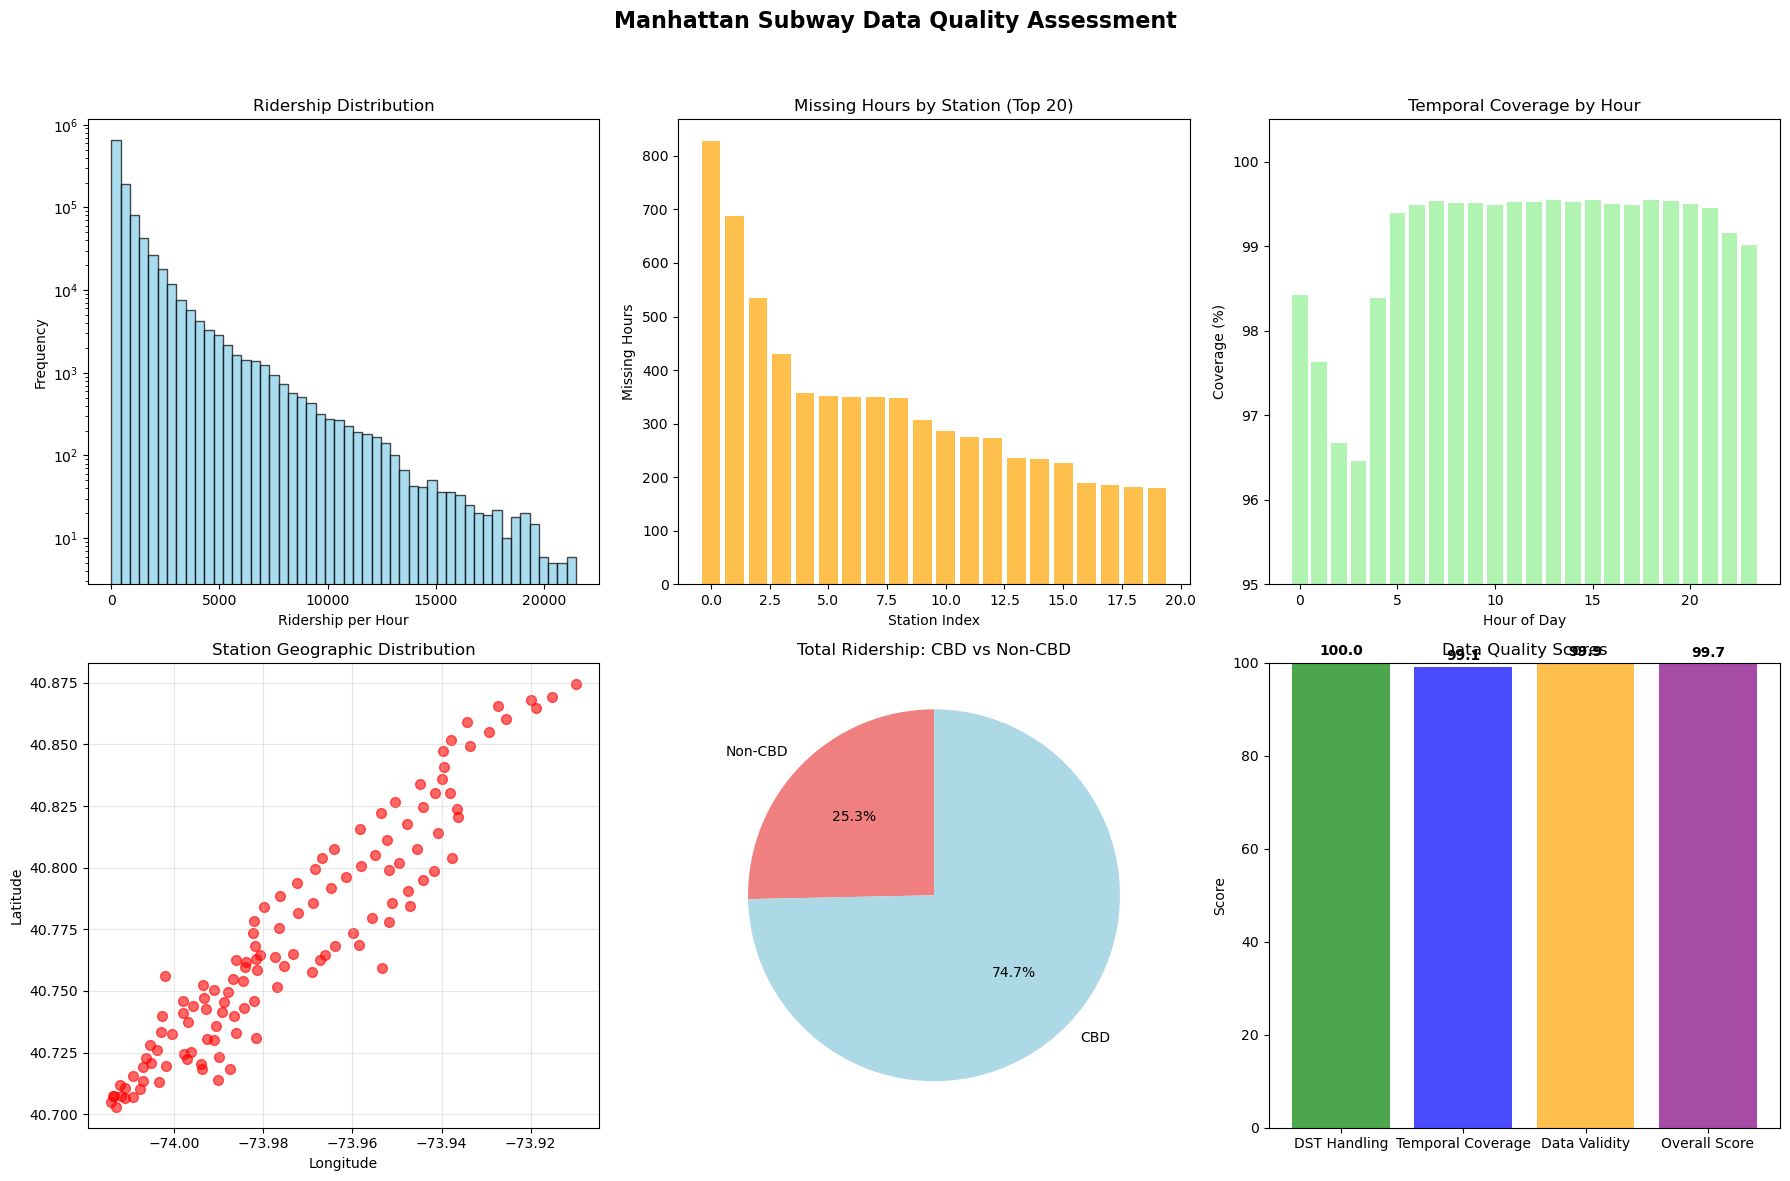


Figure saved to: C:\Users\neasa\manhattan-subway\results\evaluation_plots\data_quality_summary.png


In [20]:
# ============================================
# 5. Data Quality Visualizations
# ============================================

print("\n" + "=" * 60)
print("5. DATA QUALITY VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Manhattan Subway Data Quality Assessment', fontsize=16, fontweight='bold')

# --------------------------------------------
# 5.1 Ridership Distribution
# --------------------------------------------
axes[0, 0].hist(integrated_df['ridership'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Ridership Distribution')
axes[0, 0].set_xlabel('Ridership per Hour')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# --------------------------------------------
# 5.2 Missing Data by Station
# --------------------------------------------
if stations_missing_data:
    station_ids = [s['station_id'] for s in stations_missing_data[:20]]
    missing_hours = [s['missing_hours'] for s in stations_missing_data[:20]]

    axes[0, 1].bar(range(len(station_ids)), missing_hours, color='orange', alpha=0.7)
    axes[0, 1].set_title('Missing Hours by Station (Top 20)')
    axes[0, 1].set_xlabel('Station Index')
    axes[0, 1].set_ylabel('Missing Hours')
else:
    axes[0, 1].text(0.5, 0.5, 'No Missing Data\nPerfect Coverage',
                   ha='center', va='center', transform=axes[0, 1].transAxes,
                   fontsize=14, fontweight='bold', color='green')
    axes[0, 1].set_title('Missing Data Analysis')

# --------------------------------------------
# 5.3 Hourly Coverage Pattern
# --------------------------------------------
hourly_coverage_pct = []
for hour in range(24):
    actual_count = hourly_coverage.get(hour, 0)
    expected = len(common_stations) * (365 if hour == 2 else 366)
    coverage_pct = (actual_count / expected) * 100 if expected > 0 else 0
    hourly_coverage_pct.append(coverage_pct)

axes[0, 2].bar(range(24), hourly_coverage_pct, color='lightgreen', alpha=0.7)
axes[0, 2].set_title('Temporal Coverage by Hour')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Coverage (%)')
axes[0, 2].set_ylim([95, 100.5])

# --------------------------------------------
# 5.4 Station Geographic Distribution
# --------------------------------------------
if {'latitude', 'longitude'}.issubset(integrated_df.columns):
    station_coords = integrated_df[['station_complex_id', 'latitude', 'longitude']].drop_duplicates()
    axes[1, 0].scatter(station_coords['longitude'], station_coords['latitude'],
                       alpha=0.6, s=50, color='red')
    axes[1, 0].set_title('Station Geographic Distribution')
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')
    axes[1, 0].grid(True, alpha=0.3)

# --------------------------------------------
# 5.5 CBD vs Non-CBD Ridership
# --------------------------------------------
if 'is_cbd' in integrated_df.columns:
    cbd_totals = integrated_df.groupby('is_cbd')['ridership'].sum()
    labels = ['Non-CBD', 'CBD']
    axes[1, 1].pie(cbd_totals.values, labels=labels, autopct='%1.1f%%',
                  colors=['lightcoral', 'lightblue'], startangle=90)
    axes[1, 1].set_title('Total Ridership: CBD vs Non-CBD')

# --------------------------------------------
# 5.6 Data Quality Score Summary
# --------------------------------------------
actual_temporal_coverage = (len(integrated_df) / EXPECTED_TOTAL_RECORDS) * 100

quality_scores = {
    'DST Handling': 100 if quality_results.get('dst_handling', {}).get('overall_correct', False) else 70,
    'Temporal Coverage': actual_temporal_coverage,
    'Data Validity': quality_results.get('validity', {}).get('validity_score', 0),
    'Overall Score': 0
}
quality_scores['Overall Score'] = np.mean(list(quality_scores.values())[:-1])

bars = axes[1, 2].bar(quality_scores.keys(), quality_scores.values(),
                      color=['green', 'blue', 'orange', 'purple'], alpha=0.7)
axes[1, 2].set_title('Data Quality Scores')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_ylim([0, 100])

for bar, score in zip(bars, quality_scores.values()):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width() / 2., height + 1,
                    f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

# --------------------------------------------
# Final Layout & Save
# --------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()

# Ensure save directory exists and export figure
from pathlib import Path

RESULTS_DIR = Path("../results/evaluation_plots")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

fig_path = RESULTS_DIR / "data_quality_summary.png"
fig.savefig(fig_path, dpi=300)
print(f"\nFigure saved to: {fig_path.resolve()}")

# Store final quality score
final_quality_score = quality_scores['Overall Score']


In [21]:
# ============================================
# 6. Final Data Preparation and Export
# ============================================

print("\n" + "=" * 60)
print("6. FINAL DATA PREPARATION AND EXPORT")
print("=" * 60)

# --------------------------------------------
# Add derived temporal features
# --------------------------------------------
print("Adding essential temporal features...")

integrated_df['hour'] = integrated_df['transit_timestamp'].dt.hour
integrated_df['day_of_week'] = integrated_df['transit_timestamp'].dt.dayofweek  # 0 = Monday
integrated_df['month'] = integrated_df['transit_timestamp'].dt.month
integrated_df['date'] = integrated_df['transit_timestamp'].dt.date

print("Added: hour, day_of_week, month, date")

# --------------------------------------------
# Dataset summary
# --------------------------------------------
print("\n--- FINAL INTEGRATED DATASET STRUCTURE ---")
print(f"Shape:         {integrated_df.shape}")
print(f"Columns:       {list(integrated_df.columns)}")
print(f"Memory usage:  {integrated_df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

print("\n--- FINAL DATA SAMPLE ---")
display(integrated_df.head())

# --------------------------------------------
# Export to standardized filename
# --------------------------------------------
CLEANED_DATA_FILE = PROCESSED_DIR / "subway_data_cleaned.parquet"

try:
    integrated_df.to_parquet(CLEANED_DATA_FILE, index=False)
    file_size_mb = CLEANED_DATA_FILE.stat().st_size / (1024 ** 2)
    print(f"\nExported cleaned dataset to: {CLEANED_DATA_FILE}")
    print(f"File size: {file_size_mb:.1f} MB")
except Exception as e:
    print(f"ERROR: Failed to export dataset to {CLEANED_DATA_FILE}")
    print(str(e))



6. FINAL DATA PREPARATION AND EXPORT
Adding essential temporal features...
Added: hour, day_of_week, month, date

--- FINAL INTEGRATED DATASET STRUCTURE ---
Shape:         (1052709, 11)
Columns:       ['station_complex_id', 'station_complex', 'transit_timestamp', 'ridership', 'latitude', 'longitude', 'is_cbd', 'hour', 'day_of_week', 'month', 'date']
Memory usage:  177.2 MB

--- FINAL DATA SAMPLE ---


,station_complex_id,station_complex,transit_timestamp,ridership,latitude,longitude,is_cbd,hour,day_of_week,month,date
0,8,"5 Av/59 St (N,R,W)",2024-01-01 00:00:00,1141,40.764811,-73.973347,1,0,0,1,2024-01-01
1,8,"5 Av/59 St (N,R,W)",2024-01-01 01:00:00,351,40.764811,-73.973347,1,1,0,1,2024-01-01
2,8,"5 Av/59 St (N,R,W)",2024-01-01 02:00:00,94,40.764811,-73.973347,1,2,0,1,2024-01-01
3,8,"5 Av/59 St (N,R,W)",2024-01-01 03:00:00,27,40.764811,-73.973347,1,3,0,1,2024-01-01
4,8,"5 Av/59 St (N,R,W)",2024-01-01 04:00:00,11,40.764811,-73.973347,1,4,0,1,2024-01-01



Exported cleaned dataset to: C:\Users\neasa\manhattan-subway\data\processed\subway_data_cleaned.parquet
File size: 3.7 MB


In [22]:
# ============================================
# Generate Final Quality Assessment
# ============================================

print("\n" + "=" * 60)
print("7. GENERATING QUALITY ASSESSMENT SUMMARY")
print("=" * 60)

# Define standardized output file path
QUALITY_JSON = PROCESSED_DIR / "subway_data_quality_assessment.json"

# Final score
final_quality_score = quality_scores['Overall Score']

# Compile quality report
final_assessment = {
    'analysis_timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_records': len(integrated_df),
        'unique_stations': integrated_df['station_complex_id'].nunique(),
        'date_range': {
            'start': integrated_df['transit_timestamp'].min().isoformat(),
            'end': integrated_df['transit_timestamp'].max().isoformat()
        },
        'temporal_coverage_days': (
            integrated_df['transit_timestamp'].max() - integrated_df['transit_timestamp'].min()
        ).days + 1,
        'temporal_coverage_percentage': actual_temporal_coverage
    },
    'quality_scores': quality_scores,
    'quality_details': quality_results,
    'data_issues': {
        'stations_missing_data': len(stations_missing_data),
        'total_missing_records': EXPECTED_TOTAL_RECORDS - len(integrated_df),
        'validity_issues': quality_results.get('validity', {}).get('total_issues', 0)
    },
    'recommendations': []
}

# Recommendation logic
if final_quality_score >= 95:
    final_assessment['recommendations'].append("EXCELLENT: Dataset ready for advanced modeling")
elif final_quality_score >= 85:
    final_assessment['recommendations'].append("VERY GOOD: High quality dataset, proceed with modeling")
elif final_quality_score >= 75:
    final_assessment['recommendations'].append("GOOD: Acceptable quality with minor gaps, proceed with modeling")
else:
    final_assessment['recommendations'].append("REVIEW REQUIRED: Address quality issues before modeling")

# DST validation message
if quality_results.get('dst_handling', {}).get('overall_correct', False):
    final_assessment['recommendations'].append("DST handling is correct")
else:
    final_assessment['recommendations'].append("Review DST handling implementation")

# Missing station coverage message
if stations_missing_data:
    if actual_temporal_coverage >= 99:
        msg = f"{len(stations_missing_data)} stations have minor missing data ({actual_temporal_coverage:.1f}% coverage)"
    elif actual_temporal_coverage >= 95:
        msg = f"{len(stations_missing_data)} stations have some missing data ({actual_temporal_coverage:.1f}% coverage)"
    else:
        msg = f"{len(stations_missing_data)} stations have significant missing data ({actual_temporal_coverage:.1f}% coverage)"
    final_assessment['recommendations'].append(msg)

# Save JSON
try:
    with open(QUALITY_JSON, 'w') as f:
        json.dump(final_assessment, f, indent=2, default=str)
    print(f"Saved quality assessment to: {QUALITY_JSON}")
except Exception as e:
    print(f"ERROR: Failed to write quality assessment JSON\n{e}")



7. GENERATING QUALITY ASSESSMENT SUMMARY
Saved quality assessment to: C:\Users\neasa\manhattan-subway\data\processed\subway_data_quality_assessment.json


In [23]:
# ============================================
# Executive Summary
# ============================================

print("\n" + "=" * 60)
print("EXECUTIVE SUMMARY")
print("=" * 60)

# Determine quality label
if final_quality_score >= 90:
    status = "EXCELLENT"
elif final_quality_score >= 80:
    status = "GOOD"
else:
    status = "NEEDS REVIEW"

# Dataset metadata
total_records = len(integrated_df)
unique_stations = integrated_df['station_complex_id'].nunique()
date_range_start = integrated_df['transit_timestamp'].min().strftime('%Y-%m-%d')
date_range_end = integrated_df['transit_timestamp'].max().strftime('%Y-%m-%d')
coverage_pct = (total_records / EXPECTED_TOTAL_RECORDS) * 100

print(f"FINAL QUALITY SCORE: {final_quality_score:.1f}/100")
print(f"DATASET STATUS: {status}")

print("\nDATASET CHARACTERISTICS:")
print(f"• Total Records:               {total_records:,}")
print(f"• Station Complexes:           {unique_stations}")
print(f"• Date Range:                  {date_range_start} to {date_range_end}")
print(f"• Temporal Coverage:           {coverage_pct:.2f}%")

print("\nQUALITY ASSESSMENT:")
print(f"• DST Handling:                {'CORRECT' if quality_results['dst_handling']['overall_correct'] else 'ISSUES'}")
print(f"• Data Validity Score:         {quality_results['validity']['validity_score']:.1f}/100")
print(f"• Stations with Perfect Data:  {quality_results['temporal_completeness']['perfect_stations']} of {len(common_stations)}")

print("\nNEXT STEPS:")
print("1. Subway data integration complete")
print("2. Proceed to weather data preprocessing")
print("3. Final dataset integration for modeling")

print("\n" + "=" * 60)
print("SUBWAY DATA INTEGRATION COMPLETED SUCCESSFULLY")
print("=" * 60)



EXECUTIVE SUMMARY
FINAL QUALITY SCORE: 99.7/100
DATASET STATUS: EXCELLENT

DATASET CHARACTERISTICS:
• Total Records:               1,052,709
• Station Complexes:           121
• Date Range:                  2024-01-01 to 2024-12-31
• Temporal Coverage:           99.06%

QUALITY ASSESSMENT:
• DST Handling:                CORRECT
• Data Validity Score:         99.9/100
• Stations with Perfect Data:  33 of 121

NEXT STEPS:
1. Subway data integration complete
2. Proceed to weather data preprocessing
3. Final dataset integration for modeling

SUBWAY DATA INTEGRATION COMPLETED SUCCESSFULLY
